# Pairs Trading

Ming Wee G.

Pairs trading is a market-neutral trading strategy that involves identifying two assets (usually stocks) that have a high correlation. The core idea is to exploit temporary deviations from their historical price relationship by trading the pair, with the expectation that the prices will revert to their mean over time.

Once the pair is selected, the price ratio between the two assets is calculated, for instance, (price of stock A) / (price of stock B) at time t.

Pairs trading is based on the mean-reversion principle, which assumes that the price ratio between the two assets will revert to its historical mean. When the ratio deviates from the mean, it is expected to eventually return, offering a trading opportunity.

Buy Signal: When the ratio deviates below its historical mean by a certain threshold (e.g., one standard deviation), it signals that one asset (e.g., Stock A) is undervalued relative to the other (e.g., Stock B). The strategy suggests buying Stock A and shorting Stock B, betting that the ratio will increase back toward the mean.

Sell Signal: Conversely, when the ratio exceeds its historical mean by a certain threshold, it indicates that one asset (e.g., Stock A) is overvalued relative to the other (e.g., Stock B). The strategy suggests shorting Stock A and buying Stock B, anticipating that the ratio will decrease back toward the mean.

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

### Importing Data

We first import stock price data from Yahoo Finance from 2023/08/11 to 2024/08/11, a one year time period. 

In [2]:
def get_historical_data(tickers):
    df = pd.DataFrame()
    names = []
    for ticker in tickers:
        df = pd.concat([df, pd.DataFrame(yf.download(ticker, start=datetime(2023, 8, 11), end=datetime(2024, 8, 11)).iloc[:,4])], axis=1)
        names.append(ticker)
    df.columns = names
    return df

companies = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT","GS","XOM","NKE","META","BRK-B", "MSFT"]
df = get_historical_data(companies)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,GS,XOM,NKE,META,BRK-B,MSFT
Date,,,,,,,,,,,,,,,
2023-08-11,389.363983,176.884857,130.022034,107.570000,20.190001,439.502502,421.660004,235.720001,53.017635,330.799927,107.163330,106.568504,301.021454,358.350006,317.945282
2023-08-14,392.742279,178.546371,131.680161,111.980003,19.959999,441.928589,427.779999,236.710007,52.622963,327.897064,107.249557,106.124840,305.562103,358.480011,320.946350
2023-08-15,389.018250,176.546600,130.121933,111.349998,19.330000,436.780579,423.700012,232.259995,52.353271,322.528198,104.496117,105.050194,301.330780,354.500000,318.787109
2023-08-16,384.365662,175.671082,128.963242,107.190002,18.590000,433.575409,415.450012,229.949997,52.379581,319.518524,102.737762,105.030464,293.686493,354.109985,318.012970
2023-08-17,377.638672,173.114151,130.311722,104.440002,18.379999,430.271606,403.000000,224.539993,51.205429,317.974884,104.727982,103.571297,284.505371,353.190002,314.519226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,429.220001,209.028061,160.639999,134.820007,20.650000,517.380005,598.549988,167.029999,67.397888,459.019989,113.853378,71.419998,475.730011,413.720001,394.439056
2024-08-06,428.980011,206.990402,160.539993,130.179993,21.280001,522.150024,609.570007,165.039993,67.547462,470.220001,113.248260,72.500000,494.089996,422.140015,398.891022
2024-08-07,427.570007,209.577423,160.750000,128.669998,20.830000,518.659973,611.479980,163.240005,66.719826,473.010010,114.756119,72.620003,488.920013,427.019989,397.713165


### Choosing the pair of stocks based on correlation & cointegration

In [13]:
corr_matrix = df.corr()
corr_matrix

,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,GS,XOM,NKE,META,BRK-B,MSFT
DPZ,1.000000,0.282283,0.818216,0.712851,0.397399,0.858452,0.869677,-0.483162,0.725886,0.818478,0.567946,-0.409460,0.840832,0.788109,0.823935
AAPL,0.282283,1.000000,0.662639,0.200007,0.653950,0.588767,0.492384,-0.050413,0.633034,0.649213,0.084107,-0.479627,0.350954,0.442626,0.545351
GOOG,0.818216,0.662639,1.000000,0.512713,0.613270,0.880606,0.826100,-0.566992,0.891466,0.908316,0.606756,-0.685882,0.762468,0.785212,0.820501
AMD,0.712851,0.200007,0.512713,1.000000,0.106165,0.792906,0.828788,-0.248177,0.529630,0.650896,0.129840,-0.188082,0.852361,0.738393,0.844798
GME,0.397399,0.653950,0.613270,0.106165,1.000000,0.484393,0.404697,-0.146827,0.586264,0.565014,0.318094,-0.432755,0.283356,0.389368,0.353069
SPY,0.858452,0.588767,0.880606,0.792906,0.484393,1.000000,0.972012,-0.458278,0.891648,0.960084,0.498854,-0.587460,0.935654,0.942514,0.952861
NFLX,0.869677,0.492384,0.826100,0.828788,0.404697,0.972012,1.000000,-0.482653,0.854956,0.903919,0.469732,-0.508794,0.955726,0.921504,0.963226
BA,-0.483162,-0.050413,-0.566992,-0.248177,-0.146827,-0.458278,-0.482653,1.000000,-0.663033,-0.448122,-0.719962,0.677980,-0.573214,-0.552256,-0.427746
WMT,0.725886,0.633034,0.891466,0.529630,0.586264,0.891648,0.854956,-0.663033,1.000000,0.897651,0.655283,-0.787719,0.817265,0.872926,0.801229
GS,0.818478,0.649213,0.908316,0.650896,0.565014,0.960084,0.903919,-0.448122,0.897651,1.000000,0.540187,-0.650548,0.845512,0.907080,0.877756


<AxesSubplot:>

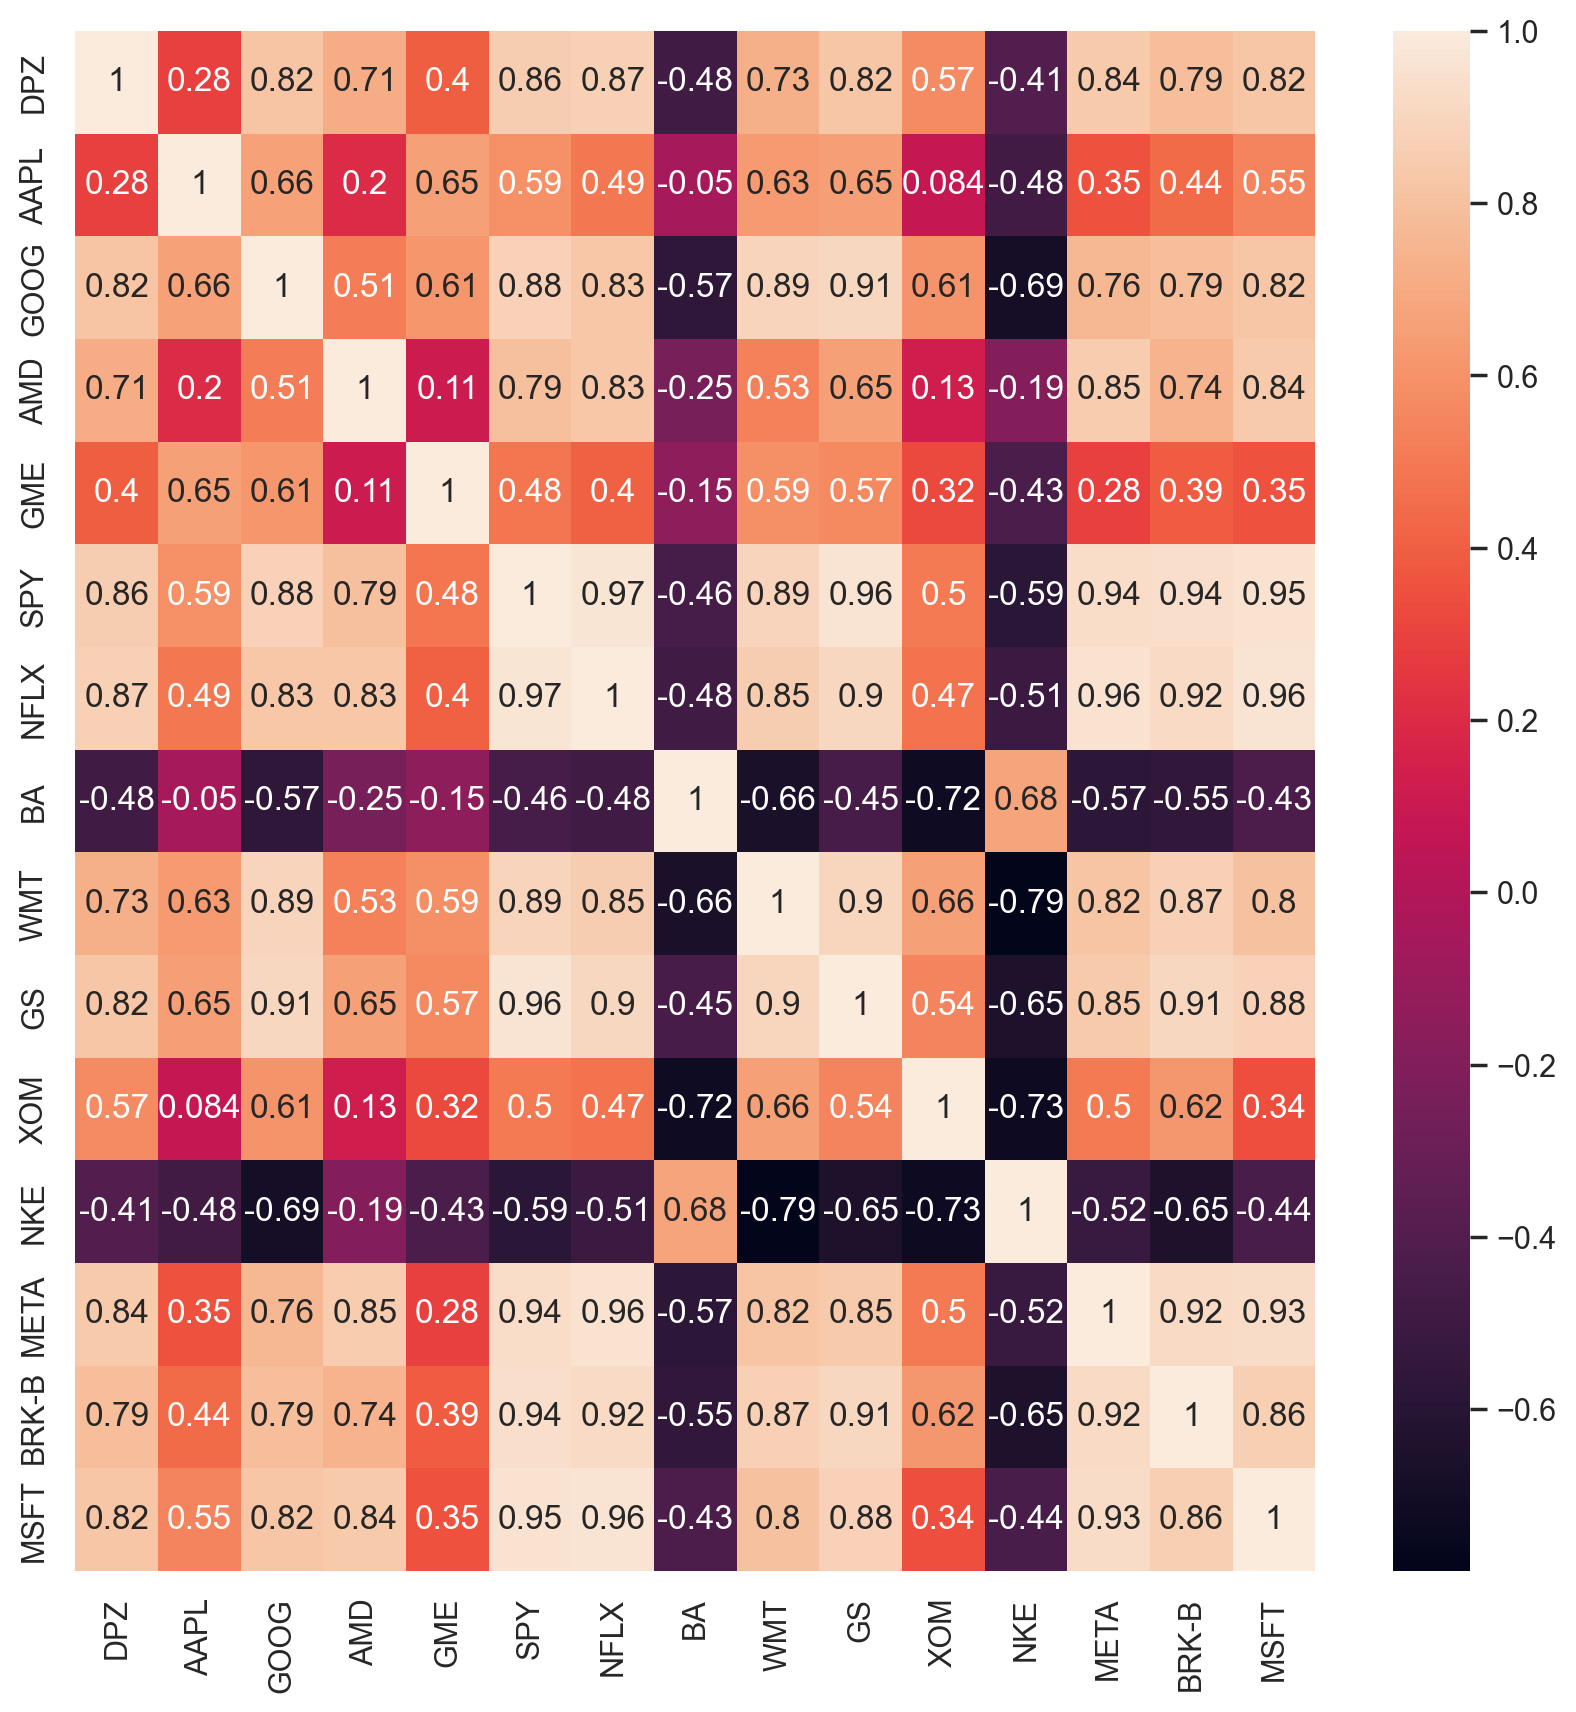

In [14]:
import seaborn as sn
from matplotlib.pyplot import figure
figure(figsize=(10,10), dpi=200)
sn.heatmap(corr_matrix, annot=True)

In [15]:
# Function to find co-integrated pairs of stocks
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

[('SPY', 'NFLX'), ('NFLX', 'META')]


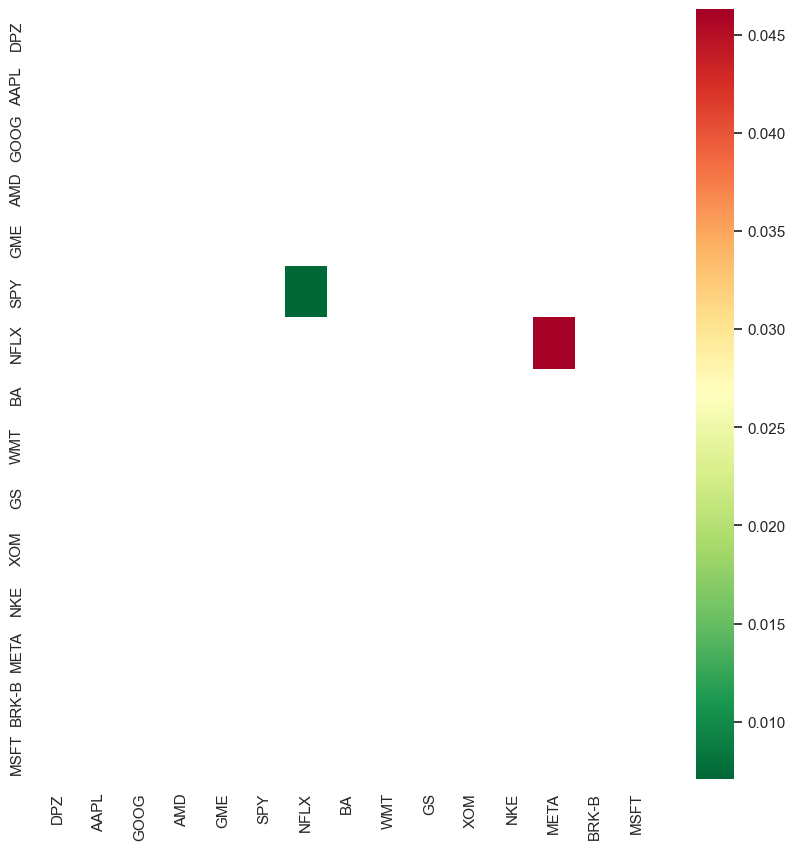

In [16]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

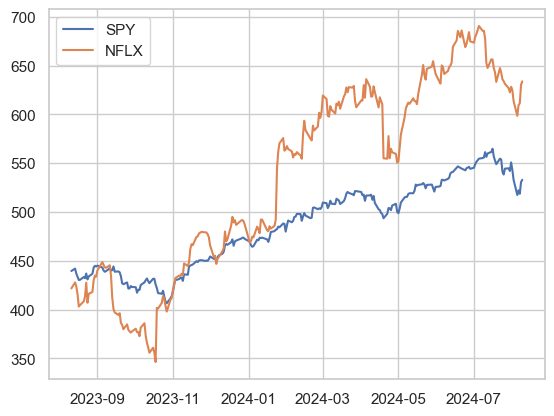

In [17]:
# SPY vs NFLX (Corr = 0.97)

import matplotlib.pyplot as plt
spy = df['SPY']
nflx = df['NFLX']
plt.plot(spy, label='SPY')
plt.plot(nflx, label='NFLX')
plt.legend()

We can see that NFLX is both cointegrated and highly correlated with the whole market, SPY. 
Thus, let's trade on NFLX - SPY pair.

### Generating Buy & Sell Signals for trades

Text(0.5, 1.0, 'Ratio Time Series between SPY and NFLX')

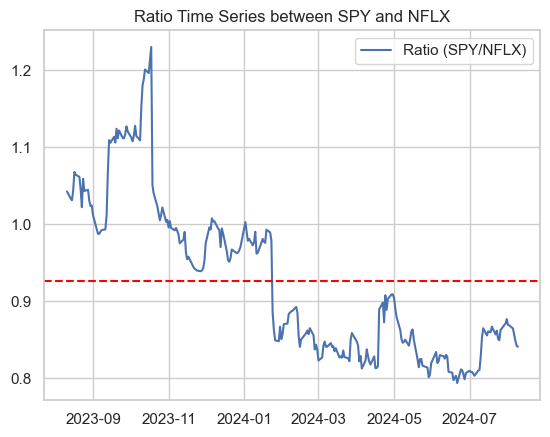

In [18]:
# Plotting Ratio
ratio = spy / nflx
plt.plot(ratio, label = 'Ratio (SPY/NFLX)')
plt.axhline(ratio.mean(), color = 'red', linestyle = '--')
plt.legend()
plt.title("Ratio Time Series between SPY and NFLX")

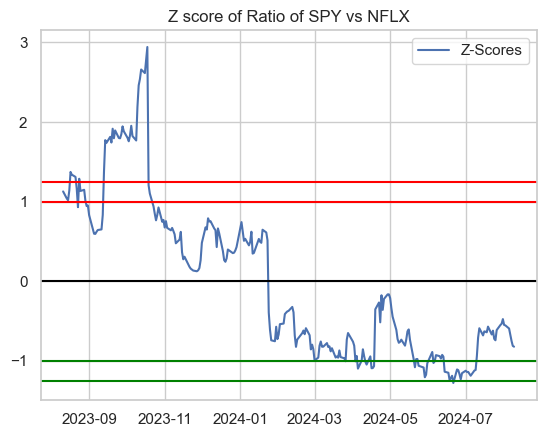

In [19]:
# Calculating Zscores of the ratio time series
zscores = (ratio - ratio.mean())/ratio.std()
plt.plot(zscores, label = 'Z-Scores')
plt.axhline(zscores.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of SPY vs NFLX')
plt.show()

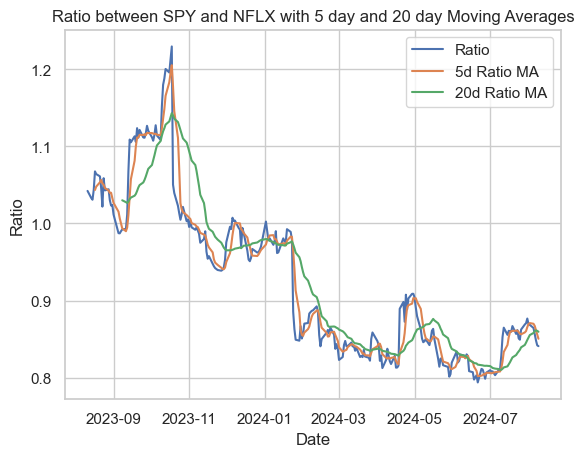

In [20]:
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between SPY and NFLX with 5 day and 20 day Moving Averages')
plt.show()

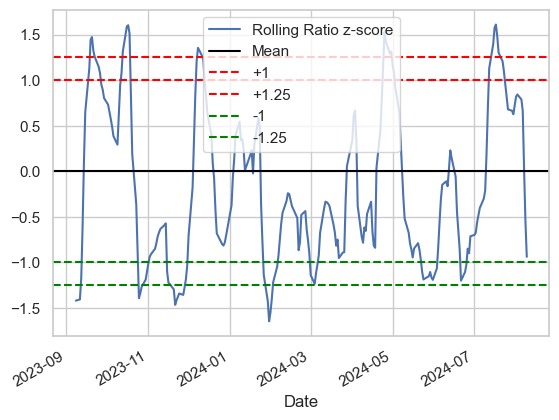

In [35]:
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

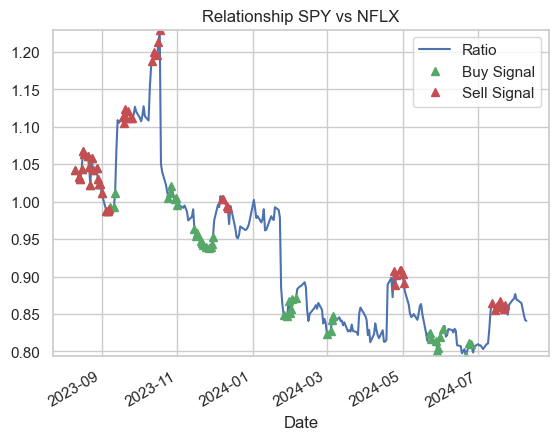

In [36]:
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship SPY vs NFLX')
plt.show()


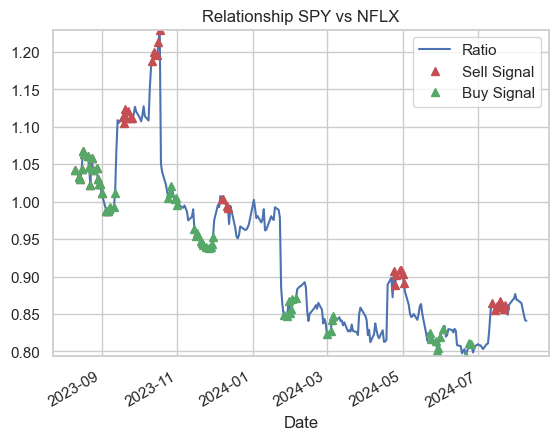

In [40]:
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0

sell.plot(color='r', linestyle='None', marker='^')
buy.plot(color='g', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Sell Signal', 'Buy Signal'])
plt.title('Relationship SPY vs NFLX')
plt.show()